In [1]:
from bs4 import BeautifulSoup             
import os
import re
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt


import gensim
from gensim import models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

from gensim.corpora import Dictionary

In [58]:
def cm_to_inch(value):
    return value/2.54

/home/gabriel/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
stemmer = SnowballStemmer('english')
stops = set(stopwords.words("english"))

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def lyric_to_words( raw_lyric ):
    lyric_text = BeautifulSoup(raw_lyric, features="lxml").get_text() 
    letters_only = re.sub("[^a-zA-Z]", " ", lyric_text) 
    words = letters_only.lower().split()                                               
    meaningful_words = [w for w in words if not w in stops]
    lemmatize_stemming_words = [lemmatize_stemming(w) for w in words] 

    return lemmatize_stemming_words
    # return( " ".join( meaningful_words ))

In [3]:
data_set = pd.read_csv("tcc_ceds_music.csv", delimiter=",")
data_set = data_set.drop(["dating", "violence", "world/life", "night/time", "family/gospel", "shake the audience", "dating", "violence", "world/life", "sadness", "feelings", "danceability", "loudness",	"acousticness",	"instrumentalness",	"valence",	"energy", "topic", "romantic",	"communication",	"obscene",	"music",	"movement/places",	"light/visual perceptions",	"family/spiritual",	"like/girls", "age"], axis=1)
data_set.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len
0,0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95
1,4,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51
2,6,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24
3,10,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54
4,12,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48


In [4]:
%%time
processed_lyrics = data_set['lyrics'].map(lyric_to_words)

CPU times: user 22.9 s, sys: 141 ms, total: 23 s
Wall time: 23.1 s


In [5]:
data_set['processed_lyrics'] = processed_lyrics

In [6]:
%%time
dictionary = Dictionary(processed_lyrics)

CPU times: user 951 ms, sys: 0 ns, total: 951 ms
Wall time: 950 ms


In [7]:
%%time
dictionary.filter_extremes(no_below=15, no_above=0.25, keep_n=100000)

CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 42.4 ms


In [8]:
%%time
corpus = [dictionary.doc2bow(lyric) for lyric in processed_lyrics]

CPU times: user 513 ms, sys: 12 ms, total: 525 ms
Wall time: 525 ms


In [9]:
%%time
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=100)

CPU times: user 2min 28s, sys: 12.5 s, total: 2min 40s
Wall time: 2min 41s


In [12]:
topics = [sorted(lda_model[c], key=lambda tup: -1*tup[1])[0][0] for c in corpus]
data_set["topics"] = topics

In [13]:
data_set.to_csv("tcc_ceds_music_topics.csv", index=0)

In [14]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(
    lda_model,
    corpus,
    dictionary,
    sort_topics=False,
)
pyLDAvis.display(lda_display)

In [ ]:
decadas = [item for item in range(1950, 2020, 10)]
topic_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

/home/gabriel/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


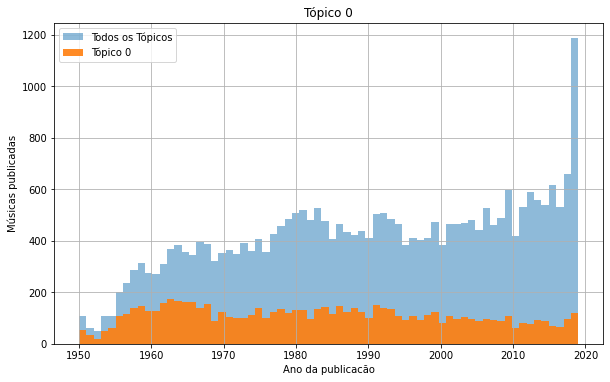

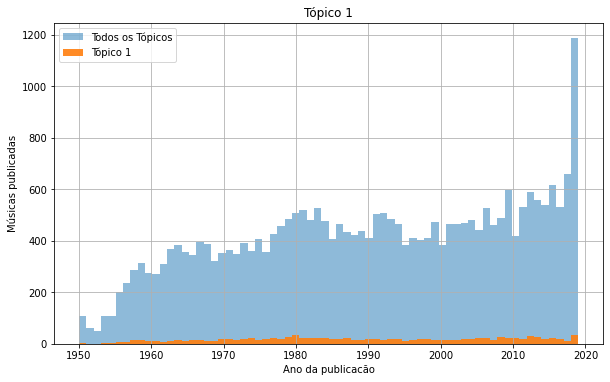

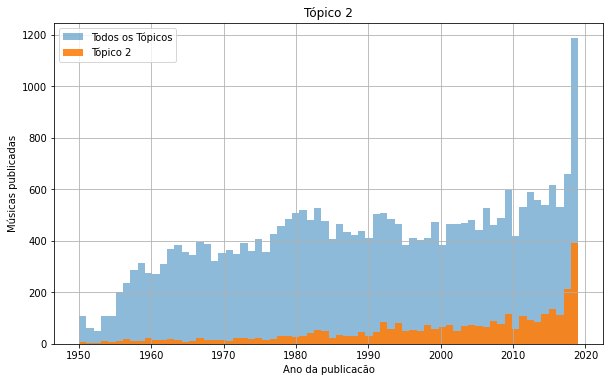

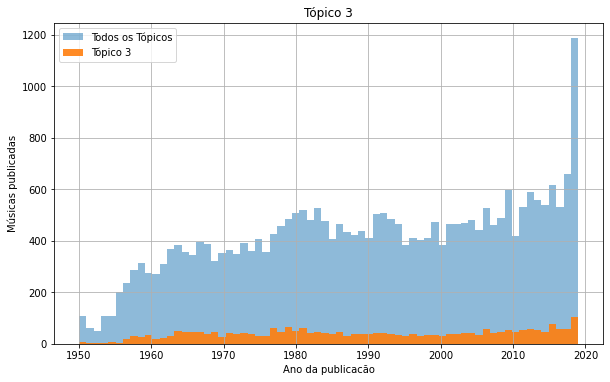

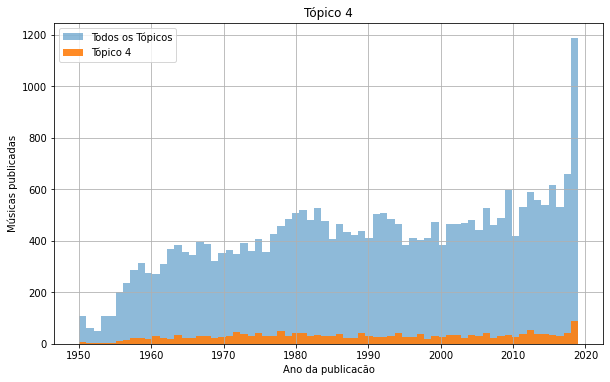

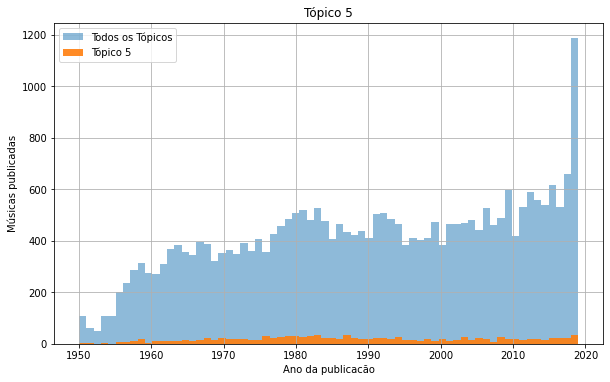

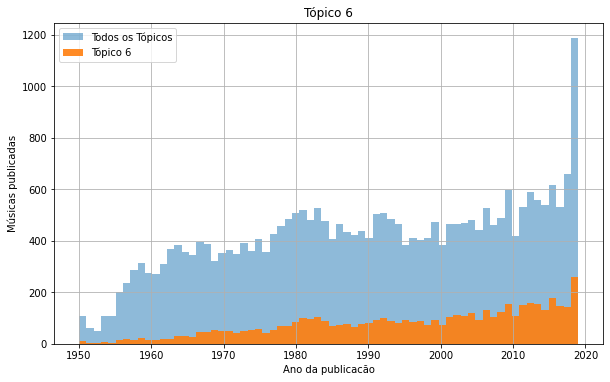

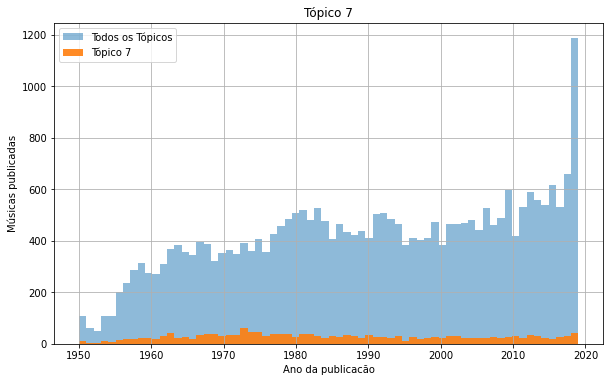

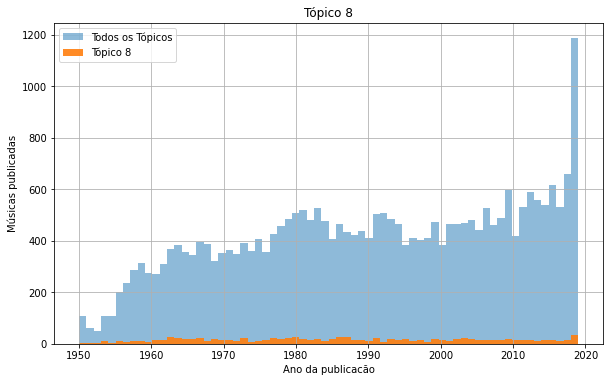

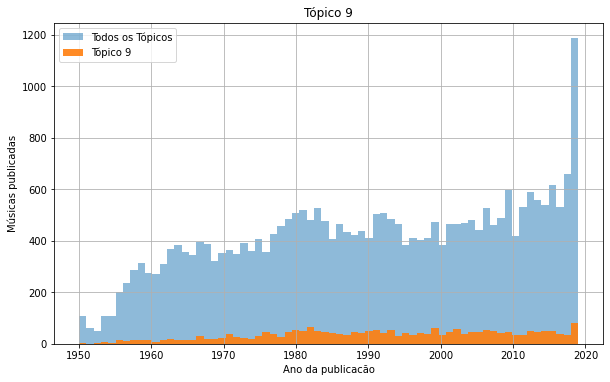

In [67]:
for i in range(10):
    plt.figure(figsize=(cm_to_inch(25), cm_to_inch(15)))
    data_set_topic = data_set[(data_set["topics"] == i)]
    data_set_topic = data_set_topic.loc[:,["topics","release_date"]]
    data_set["release_date"].plot.hist(grid=True, bins=68, alpha=0.5, label='Todos os Tópicos')
    data_set_topic["release_date"].plot.hist(grid=True, bins=68, alpha=0.9, label=f'Tópico {topic_names[i]}')
    plt.xlabel('Ano da publicacão')
    plt.ylabel('Músicas publicadas')
    plt.title(f'Tópico {topic_names[i]}')
    # maxfreq = n.max()
    # # Set a clean upper y-axis limit.
    # plt.ylim(400)
    plt.legend()
    plt.savefig(f'plots/topico{topic_names[i]}.png')
    plt.show()
    




/home/gabriel/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


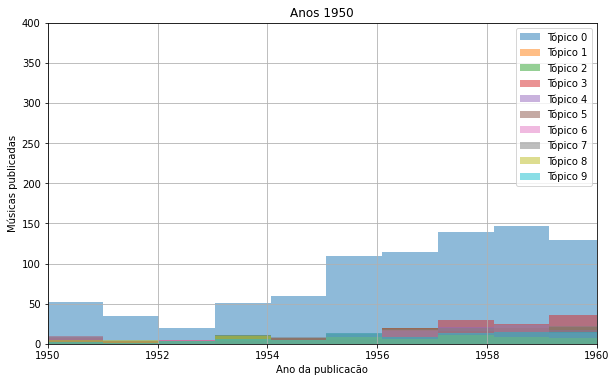

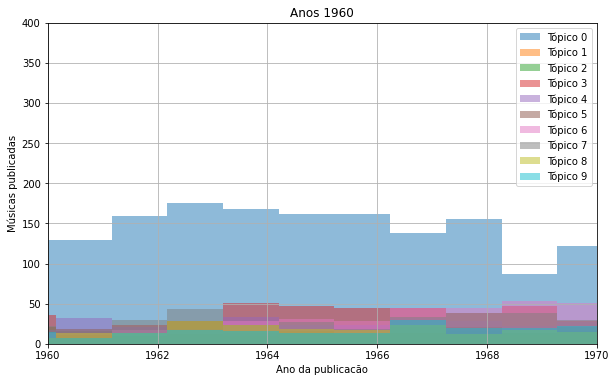

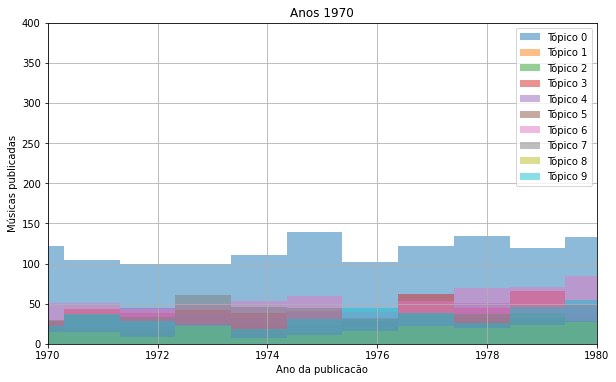

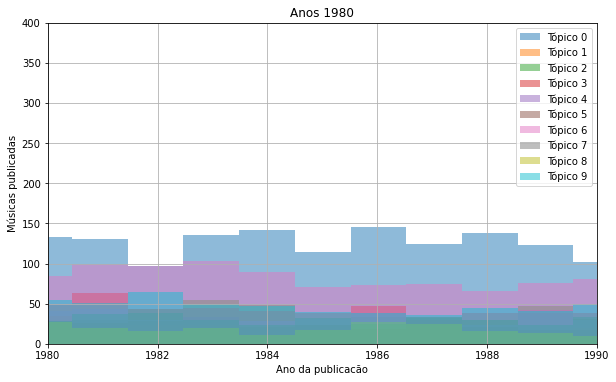

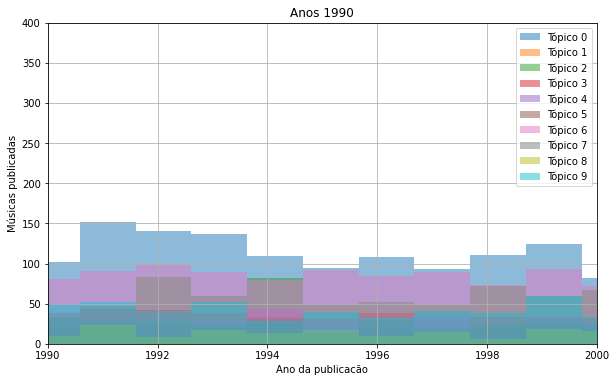

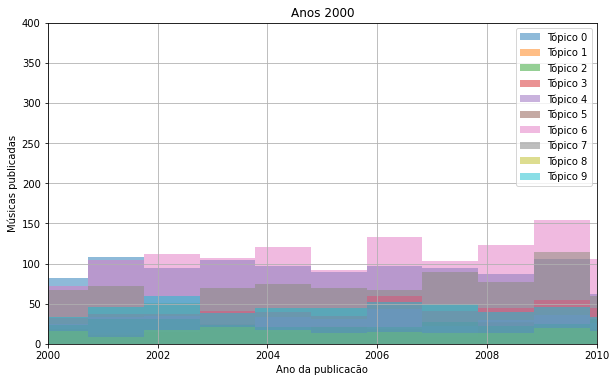

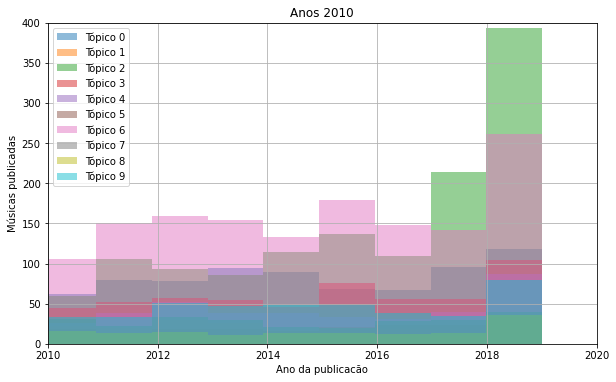

In [66]:
for i in range(len(decadas)):
    plt.figure(figsize=(cm_to_inch(25), cm_to_inch(15)))
    for j in range(len(topic_names)):

        data_set_topic = data_set[(data_set["topics"] == j)]
        data_set_topic = data_set_topic.loc[:,["topics","release_date"]]
        data_set_topic["release_date"].plot.hist(grid=True, bins=68, alpha=0.5, label=f'Tópico {topic_names[j]}')

    plt.xlabel('Ano da publicacão')
    plt.ylabel('Músicas publicadas')
    plt.title(f'Anos {decadas[i]}')
    
    # maxfreq = n.max()
    # # Set a clean upper y-axis limit.
    # plt.ylim(400)
    plt.legend()
    plt.axis([decadas[i], decadas[i]+10, 0, 400])
    plt.savefig(f'plots/anos{decadas[i]}.png')
    plt.show()